<img src='getty_626660256_2000108620009280158_388846.jpg' style="height: 50%" ></img>

# Sound Track Cleansing Demo
### Signal Processing with SAS Viya

This demo uses CAS Action Sets via the Python SWAT package to untangle audio signals.

The Cocktail Party Effect refers to the phenomenon that the human brain can identify audio signals while filtering out other stimuli.

For a computer, this is inherently difficult since the audio signals are mixed. Unsupervised Machine Learning can help us to estimate the independent components in our mixed signals.

This demo uses the fastICA algorithm to separate 4 mixed audio signals from two distinct stereo tracks into two distinct mono audio signals.

In [25]:
%matplotlib inline 

In [1]:
# Setup SWAT session
import pandas as pd
import swat
import getpass
host = getpass.getpass()
user = getpass.getpass()
password=getpass.getpass()
conn = swat.CAS(host, 5570, user, password, caslib="CASUSER")

 ····················
 ······
 ············


In [2]:
# Load SciPy library for ingesting WAV files
from scipy.io import wavfile
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import IPython

### Loading Data

We have two source signals to work with. Each file uses Stereo audio. There are two beats but the beats are mixed (i.e. there is a bit left and a bit right in each signal)

The two distinct components come from an EDM soundboard. One is a 'laser' sound, the other is a bassline.

### Source 1

Source one has the laser leaning right and the bass leaning left. Looking at the track settings we can see that the pan is not fully to one side, meaning some signal is still held on the other side when playing in stereo.

<img src='right_left1.png'></img>
<img src='right_left2.png'></img>

Here we load the WAV file into a Python object so we can visualize the audio signals and listen to a sample of the data

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  This is separate from the ipykernel package so we can avoid doing imports until


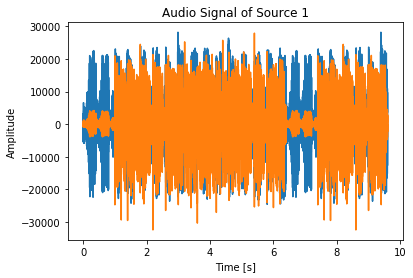

In [31]:
# Load WAV File 1
file1 = 'Right-left.wav'
samplerate1, data1 = wavfile.read(file1)
length1 = data1.shape[0] / samplerate1
import matplotlib.pyplot as plt
import numpy as np


time1 = np.linspace(0., length1, data1.shape[0])
plt.plot(time1, data1)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title('Audio Signal of Source 1')
plt.show()
IPython.display.Audio('https://github.com/HarrySnart/MixedSignals/raw/main/Right-left.wav') 

<script>
    var audio = new Audio("https://github.com/HarrySnart/MixedSignals/blob/main/Right-left.wav?raw=true");
    audio.play();
</script>

<video controls="" autoplay="" name="media">
    <source src="https://github.com/HarrySnart/MixedSignals/raw/main/Right-left.wav" type="audio/wav">
</video>

<audio controls>
  <source src="https://github.com/HarrySnart/MixedSignals/raw/main/Right-left.wav" type="audio/wav">
Your browser does not support the audio element.
</audio>

### Source 2

Our second WAV file has the opposite balance (note all balances are not perfectly symmetrical).

Below we can see how the files swap the balance from right to left and vice-versa

<img src='left_right1.png'></img>
<img src='left_right2.png'></img>

Once again, let's load the WAV file into a Python object to visualize and listen to a sample

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  This is separate from the ipykernel package so we can avoid doing imports until


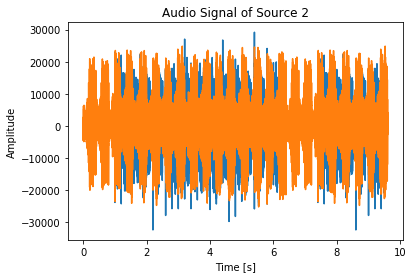

In [27]:
# Load WAV File 2
file2 = 'Left-right.wav'
samplerate2, data2 = wavfile.read(file2)
length2 = data2.shape[0] / samplerate2
import matplotlib.pyplot as plt
import numpy as np


time2 = np.linspace(0., length2, data2.shape[0])
plt.plot(time2, data2)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title('Audio Signal of Source 2')
plt.show()
IPython.display.Audio(file2) 

<audio controls>
  <source src="Left-right.wav" type="audio/wav">
</audio>

### Signal Separation using SAS Viya

Now we have our two source files loaded, we can separate them using the fastICA action. 

First, we need to merge the source signals into a single dataframe and upload the dataframe into CAS using the SWAT library

In [5]:
df1 = pd.DataFrame(data=data1, columns=["signal1", "signal2"])
df2 = pd.DataFrame(data=data2, columns=["signal3", "signal4"])

In [6]:
df = pd.concat([df1,df2],axis=1)

In [7]:
casdata = conn.upload_frame(df,casout={'name':'signals','replace':'true'})
casdata.tail()

NOTE: Cloud Analytic Services made the uploaded file available as table SIGNALS in caslib CASUSER(sukhsn).
NOTE: The table SIGNALS has been created in caslib CASUSER(sukhsn) from binary data uploaded to Cloud Analytic Services.


Selected Rows from Table SIGNALS

        signal1  signal2  signal3  signal4
423355    529.0   -995.0    697.0  -2248.0
423356    520.0   -798.0    261.0  -2656.0
423357    -15.0   -441.0   -229.0  -2703.0
423358   -818.0    -93.0   -578.0  -2421.0
423359  -1706.0    187.0   -879.0  -1797.0

We can see that our CAS Table has 423k records across 4 channels. The algorithm does not know which column comes from which WAV file either.

In [8]:
casdata.shape

(423360, 4)

We can load the actionset using the connection object. This is not mandatory when connecting via HTTP but is good practice to make it easy to move code across to a production environment using the binary protocol.

In [9]:
# Split Signal using fastICA
conn.loadactionset(actionset='ica')

NOTE: Added action set 'ica'.


[actionset]

 'ica'

+ Elapsed: 0.00155s, user: 0.000698s, sys: 0.000834s, mem: 0.207mb

### Running the fastICA action

Here we demix our audio signals using the fastICA action. Note we get two outputs, one table with our separated signals and another with the scoring information.

It is worth noting that our output is n=2, therefore we get a single (mono) track for each of our distinct audio signals. Here we use the 'symmetric' decorrelation method which calculates all of the independent components simultaneously.

In [10]:
result = conn.fastIca(
table = 'signals',inputs=['signal1','signal2','signal3','signal4'],
    method={'name':'symmetric'},
    n=2,
    displayOut={'names':{'Demixing':'demix'}},
    output = {'casOut':{'name':'scores','replace':'true'}}
)

NOTE: The CAS table 'demix' in caslib 'CASUSER(sukhsn)' has 4 rows and 3 columns.


In [11]:
print(result.ModelInfo)
print(result.Dimensions)
print(result.NObs)
print(result.CenScaleInfo)
print(result.Eigenvalues)
print(result.Whitening)
print(result.Dewhitening)
print(result.Demixing)
print(result.Mixing)
print(result.Timing)

Model Information

            Name1                             Label1                  cValue1  \
0      DataSource                        Data Source                  SIGNALS   
1          Method        Component Extraction Method  Symmetric Decorrelation   
2       GFunction  Negentropy Approximation Function                 Log-cosh   
3  EigenThreshold    Eigenvalue Proportion Threshold                        0   
4            Seed                 Random Number Seed                        0   

   nValue1  
0      NaN  
1      NaN  
2      NaN  
3      0.0  
4      0.0  
Dimensions

             RowId                                 Description  Value
0            NVARS                         Number of Variables      4
1       NWHITEVARS                Number of Whitened Variables      4
2           NCOMPS            Number of Independent Components      2
3  NCOMPSEXTRACTED  Number of Independent Components Extracted      2
Number of Observations

   RowId                  Desc

The use of Independent Component Analysis (ICA) in this example is conceptually similar to Principal Component Analysis (PCA), in that we estimate the components simultaneously via eigenvalue decomposition. In PCA we do this to express as much information as we can in the fewest number of features, there is typically an analyst decision on the number of features we want to retain. ICA differs from PCA in that instead of reducing dimensionality we seek to maximise the difference (i.e. statistical independence) in the signals in order to extract latent factors in the data (i.e. independent components). We need to specify how many indepenent components we want to extract based on our understanding of the data.

We can export the output data to a local dataframe to visualize the results of the CAS Action. 

In [12]:
# View Results
demix = conn.CASTable('demix')
demix.head()

Selected Rows from Table DEMIX

  Variable     Comp1     Comp2
0  signal1  0.152665 -2.697580
1  signal2  0.780164 -0.523387
2  signal3 -0.729185  0.352739
3  signal4 -0.184747  2.762300

In [13]:
scores = conn.CASTable('scores')
scores.tail()

Selected Rows from Table SCORES

           Comp1     Comp2
423355 -0.173964 -1.050185
423356 -0.069094 -1.275052
423357  0.044957 -1.143944
423358  0.121262 -0.747154
423359  0.168318 -0.155595

In [14]:
scores_out = scores.to_frame()

Note here that our dataframe object is actually a SASDataFrame, not Pandas Dataframe. This means we have a local cache of the data for processing but it still retains additional metadata from our source CAS table.

In [15]:
type(scores_out)

swat.dataframe.SASDataFrame

### Results of Signal Separation

Now we've ran the fastICA action on our data we can visualize and listen to our output, mono, components.

In [16]:
from scipy.io.wavfile import write

### Component 1

Let's hear the mono output file for component 1

In [17]:
# convert output signal 1 to wav
scaled1 = np.int16(scores_out.Comp1.values*1000)
write('out1.wav',samplerate1,scaled1)

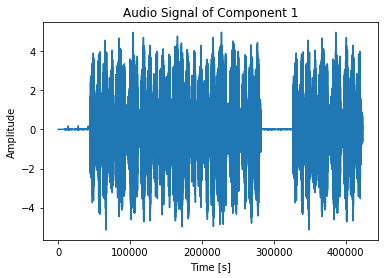

In [28]:
time = np.linspace(0., scores_out.shape[0], scores_out.shape[0])
plt.plot(time, scores_out.Comp1)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title('Audio Signal of Component 1')
plt.show()

IPython.display.Audio('out1.wav')

<audio controls>
  <source src="out1.wav" type="audio/wav">
</audio>

### Component 2

Let's hear the mono output file for component 2

In [19]:
# convert output signal 2 to wav
scaled2 = np.int16(scores_out.Comp2.values*1000)
write('out2.wav',samplerate2,scaled2)

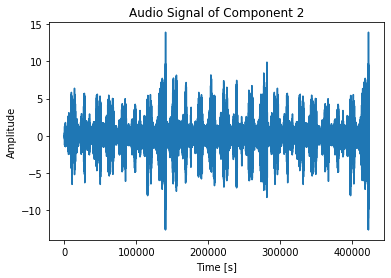

In [29]:
time = np.linspace(0., scores_out.shape[0], scores_out.shape[0])
plt.plot(time, scores_out.Comp2)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title('Audio Signal of Component 2')
plt.show()

IPython.display.Audio('out2.wav')

<audio controls>
  <source src="out2.wav" type="audio/wav">
</audio>

This simple example shows how easy it is to apply fastICA to data using SAS Viya. As well as processing audio signals, ICA can be a useful tool for other use cases, such as image pre-processing in computer vision tasks or demixing financial signals in tabular data.